In [1]:
import os
import sys
from pathlib import Path
from torch.nn import DataParallel
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import itertools

pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
functions_dir = os.path.join(Path.home(), 'el_img_cracks_ec')

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

import functions
from tutorials.unet_model import construct_unet

In [ ]:
# https://stackoverflow.com/questions/61909973/pytorch-load-incompatiblekeys

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = construct_unet(5)
unet = DataParallel(unet)

weight_path = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt'
checkpoint = torch.load(weight_path, map_location=torch.device('cpu'))

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    name = "module." + k
    new_state_dict[name] = v

unet.load_state_dict(new_state_dict)
retrained_model = unet.module.to(device)

In [ ]:
root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE')
transformers = functions.Compose([functions.FixResize(256), functions.ToTensor(), functions.Normalize()])

train_dataset = functions.SolarDataset(root, image_folder="img/train", 
        mask_folder="ann/train", transforms=transformers)

test_dataset = functions.SolarDataset(root, image_folder="img/test", 
        mask_folder="ann/test", transforms=transformers)

batch_size_test=1
batch_size_train=1

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

ann_dir = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/ann/train'

/home/eccoope/dmenv/lib64/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:78.)
  return F.conv2d(input, weight, bias, self.stride,


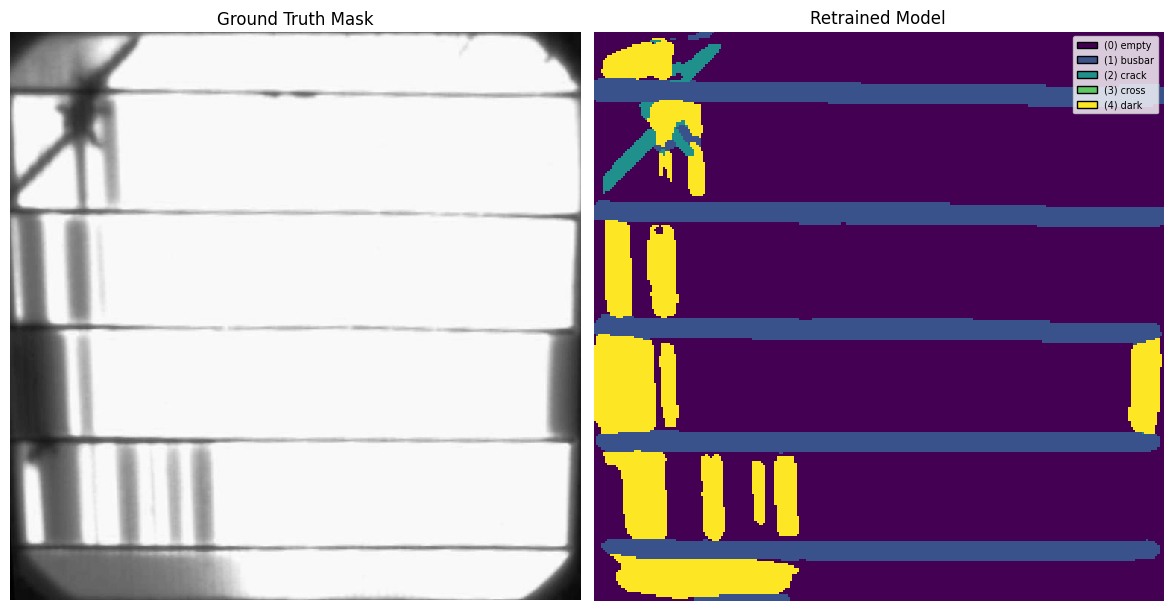

In [ ]:
cr_name = 'cr_0_EL_18.09.2023-14-38-10_unknownID_ASU Minisample_02_43.npy'
cr_idx = np.ravel(np.where(train_loader.dataset.mask_list == os.path.join(ann_dir, cr_name)))[0]
bu_name = 'bu_0_EL_18.09.2023-14-38-10_unknownID_ASU Minisample_02_43.npy'
bu_idx = np.ravel(np.where(train_loader.dataset.mask_list == os.path.join(ann_dir, bu_name)))[0]

img, mask = train_loader.dataset. __getitem__(cr_idx)
img = img.to(device)
retrained_test_res = np.argmax(retrained_model(img.unsqueeze(0)).detach().cpu().numpy().squeeze(), axis = 0)

mask_cpu = mask.cpu()
mask_cpu = functions.realign_mask(mask_cpu)

raw_img, _ = train_loader.dataset. __getraw__(cr_idx)


category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}

fig, ax = plt.subplots(ncols=2, figsize=(12,6), layout='compressed')
clim = (0, 4)
im = ax[0].imshow(raw_img.convert('L'), cmap='gray', interpolation='None')
ax[0].axis('off')
ax[0].set_title("Ground Truth Mask")

cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
cmaplist = [cmap(i) for i in range(5)]

ax[1].imshow(retrained_test_res, cmap =cmap, clim = clim, interpolation='None')

handles, labels = ax[1].get_legend_handles_labels()

for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in category_mapping.items()]):
        patch = mpatches.Patch(color=c, label=classlabel, ec='k')
        handles.append(patch)
ax[1].legend(handles=handles, fontsize='x-small')

ax[1].set_title("Retrained Model")
ax[1].axis('off');

In [5]:
def drop_empty(tensor, threshold=0.5):
    
    """
    Takes n nx by ny tensor with nz layers filled with float elements
    
    """
    
    nz, ny, nx = tensor.shape
    x, y = np.arange(nx), np.arange(ny)

    for i, j in itertools.product(y, x):
        vals = np.ravel(np.where(tensor[: , i, j] > threshold))

        if 0 in vals and len(vals) > 1:
            tensor[0, i, j] = 0
            
    return tensor

def multilabel(tensor, threshold=0.5):
    
    """
    Takes an nx by ny tensor with nz layers filled with float elements,
    and returns a nx by ny array with integer elements. If a pixel is
    labeled as more than one class, the corresponding element in the
    returned array is a concatentaed string of integers. For example, if a pixel
    at position (i, j) in the tensor is labeled as class 1 and class 2, the
    array returned will have the integer 12 in position (i, j).
    
    Parameters
    ----------
    tensor : Tensor
    threshold : float
    
    Returns
    array : array
    
    """
    nz, ny, nx = tensor.shape
    x, y = np.arange(nx), np.arange(ny)

    array = np.zeros((ny, nx), dtype=int)

    for i, j in itertools.product(y, x):

        # vals is a list
        vals = np.ravel(np.where(tensor[: , i, j] > threshold))
        # empty is an array populated with ints
        if len(vals) == 1:
            array[i, j] = vals[0]
        elif len(vals) > 1:
                
            # Sorting the list ensures that labels are in the same order,
            # so that we aren't distinguishing between 34 and 43
            
            vals_list = vals.tolist()
            vals_list.sort()
            array[i, j] = int(''.join([str(vals_list[i]) for i in np.flip(np.arange(len(vals)))]))
            
    return array


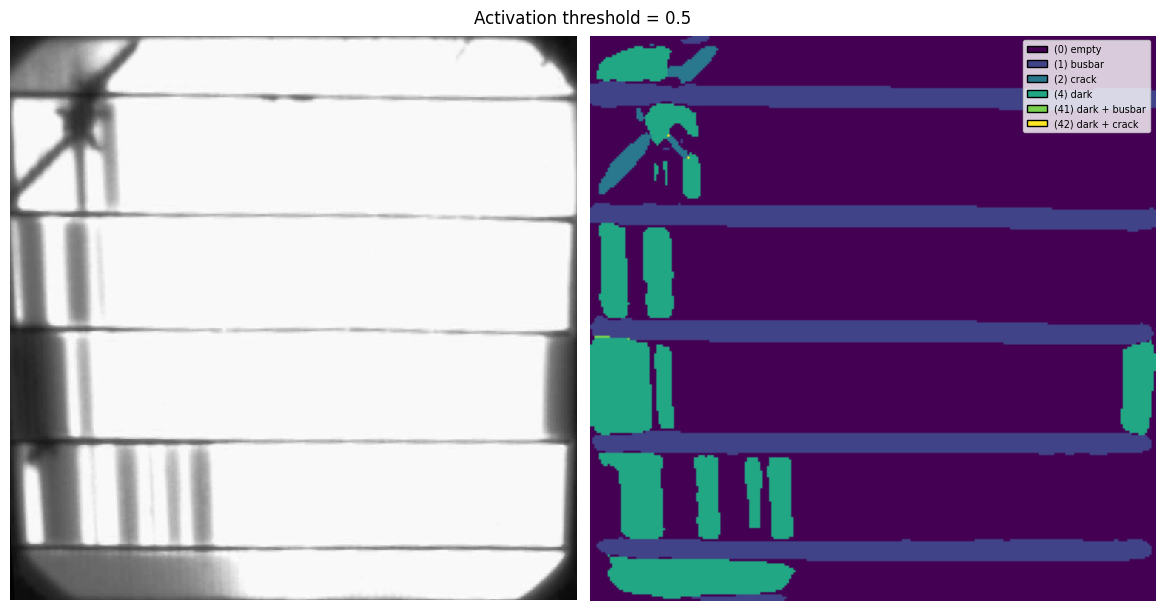

In [ ]:
test_res_chan = retrained_model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()

sigmoid = lambda x: 1 /(1 + np.exp(-x))
test_res_act = sigmoid(test_res_chan)

threshold = 0.5
tensor = drop_empty(test_res_act, threshold=threshold)

out = multilabel(tensor, threshold=threshold)
ny, nx = out.shape
x, y = np.arange(nx), np.arange(ny)

category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
    
classes = np.unique(out)
cmap = mpl.colormaps['viridis'].resampled(len(classes))
cmaplist = [cmap(i) for i in range(len(classes))]
cmapper = dict((v, c) for v, c in zip(classes, cmaplist))

color_empty = np.zeros((len(x), len(y), 3))

for x, y in itertools.product(x, y):
    color_empty[y, x] = cmapper[out[y, x]][:-1]

fig, ax = plt.subplots(ncols=2, figsize=(12,6), layout='compressed')

def map_pixels_to_label(val):
    val = int(val)
    if np.isnan(val):
        return val
    elif len(str(val)) == 2 :
        return f'({val}) {category_mapping[int(str(val)[0])]} + {category_mapping[int(str(val)[1])]}'
    elif len(str(val)) ==3 :
        return f'{category_mapping[int(str(val)[0])]} + {category_mapping[int(str(val)[1])]} + {category_mapping[int(str(val)[2])]}'
    else:
        return f'({val}) {category_mapping[val]}'
    
im = ax[0].imshow(raw_img.convert('L'), cmap='gray', interpolation='None')
ax[0].axis('off')

clim = (0,4)
ax[1].imshow(color_empty, clim=clim)

handles, labels = ax[1].get_legend_handles_labels()

for c, classlabel in zip(cmaplist, classes):
    patch = mpatches.Patch(color=c, label=map_pixels_to_label(classlabel), ec='k')
    handles.append(patch)
ax[1].legend(handles=handles, fontsize='x-small')
ax[1].axis('off')
fig.suptitle(f'Activation threshold = {threshold}');